In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from ntask.atrs import AtrModel, AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.flags import Verbosity
from ntask.utils import set_seed

In [37]:
class AtrSMA(AtrMovingAverage):
    def __init__(self, num_periods, switch_threshold_scale, switch_threshold_offset, add_threshold=0.0, max_contexts=0):
        super(AtrSMA, self).__init__(switch_threshold_offset, add_threshold, max_contexts)
        self.dyn_switch_threshold = switch_threshold_offset
        self.switch_threshold_scale = switch_threshold_scale
        self.periods = num_periods
        
    
    def build(self, num_contexts):
        super(AtrSMA, self).build(num_contexts)
        self.sma_updates = tf.Variable(np.zeros(self.num_contexts), name="SMA_Update_Count", trainable=False, dtype=tf.int64)
        self.sma_values = tf.Variable(np.zeros((self.num_contexts, self.periods)), name="SMA_Period_Values", trainable=False, dtype=tf.float64)
    
    
    def context_loss_fn(self, context_delta):
        return tf.keras.losses.mean_squared_error(np.zeros(len(context_delta)), context_delta)
    
    
    def update_atr_value(self, context_loss, switched):
        if switched or not self.values_initialized[self.hot_context]:
            self.sma_values.scatter_nd_update([[self.hot_context]], [np.zeros(self.periods)])
            self.sma_updates.scatter_nd_update([[self.hot_context]], [0])
        
        # Update the SMA values and update counter
        self.sma_values.scatter_nd_update([[self.hot_context, self.sma_updates[self.hot_context] % self.periods]], [context_loss])
        self.sma_updates.scatter_nd_add([[self.hot_context]], [1])
        
        # Calculate the mean and standard deviation
        mean = tf.math.reduce_mean(self.sma_values[self.hot_context][:self.sma_updates[self.hot_context]])
        std = tf.math.reduce_std(self.sma_values[self.hot_context])
            
        # Update the ATR and STD values
        self.set_atr_value(mean)
        self.switch_threshold.assign(self.switch_threshold_scale*tf.cast(-std, tf.float32) + self.dyn_switch_threshold)
            
#     def should_switch(self, epoch, context_loss):
#         return False
            
#     def should_add_context(self, context_loss, best_fit_context_idx):
#         return False

## Utility Functions

In [38]:
def skip_randint(max_value, skip):
    """
    Generate a new random integer between 0 and `max_value`.
    The returned value will not equal `skip`
    """
    value = np.random.randint(max_value - 1)
    return value if value < skip else (value + 1)

In [39]:
def plot(model, maze_size):
    action_values = model.predict(np.identity(maze_size)).T
    fig, ax = plt.subplots()
    x = np.arange(maze_size + 1)
    for i, label in enumerate(("left", "right")):
        values = action_values[i]
        ax.plot(x, np.concatenate((values, values[:1])), label=label)
    ax.grid()
    ax.legend()

## Q-learning

In [40]:
def policy(model, state, epsilon):
    """
    Epsilon-greedy policy selection
    """
    values = model.predict(state.reshape((1,) + state.shape))[0]
    if np.random.random() < epsilon:
        action = np.random.randint(len(values))
    else:
        action = np.argmax(values)
    return values, action

In [41]:
def update(model, prev_state, state, values, action, reward, alpha, gamma, absorb=False, **kwargs):
    """
    Perform a Q-learning update
    """
    target = np.copy(values)
    if absorb:
        target[action] = reward
    else:
        q_old = values[action]
        q_max = np.max(model.predict(state.reshape((1,) + state.shape)))
        target[action] = q_old + alpha*(reward + gamma*q_max - q_old)
    model.fit(prev_state.reshape((1,) + prev_state.shape), target.reshape((1,) + target.shape), verbose=Verbosity.Contexts, **kwargs)

In [42]:
def episode(model, goal, maze_size, limit, alpha, gamma, epsilon, **kwargs):
    states_enc = np.identity(maze_size) # state one-hot encodings
    prev_state, state = None, skip_randint(maze_size, goal)
    moves = 0
    while state != goal and moves < limit:
        
        # If there is a previous state, update the model
        if prev_state is not None:
            reward = -1
            update(model, states_enc[prev_state], states_enc[state], values, action, reward, alpha, gamma, **kwargs)
        
        # Make the prediction at the current state
        values, action = policy(model, states_enc[state], epsilon)
        
        # Move to the next state and store the previous action
        prev_state, state = state, (state + (-1 if action == 0 else 1)) % maze_size
        
        # Count the moves
        moves += 1
    
    if state == goal:
        reward = 0
        update(model, states_enc[prev_state], states_enc[state], values, action, reward, alpha, gamma, absorb=True, **kwargs)
    
    return state == goal, moves

In [43]:
def train(model, maze_size, goals, limit, episodes, alpha, gamma, epsilon, switch_freq=100, initial_shuffle=False, shuffle=False, **kwargs):
    goal_indices = np.arange(len(goals))
    goal = -1
    num_finished = 0
    for ep in range(episodes):
        if num_finished >= switch_freq or ep == 0:
            num_finished = False
            goal = (goal + 1) % len(goals)
            print("Switched to goal:", goals[goal_indices[goal]], "at epoch", ep+1)
            if shuffle or ep == 0 and initial_shuffle:
                np.random.shuffle(goal_indices)
            
        print(f"{ep+1}/{episodes}", end="\r")
        result = episode(model, goals[goal_indices[goal]], maze_size, limit, alpha, gamma, epsilon, **kwargs)
        if result[0]:
            num_finished += 1

___

## 1D Maze

In [81]:
set_seed(1)

### Maze Settings

In [82]:
# Maze Settings
maze_size = 10
goals = (0, 5)

### Model Architecture

In [83]:
# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Hyperparameters
maze_size = 10
hrr_size = 256
num_contexts = len(goals)
switch_threshold = -0.05

# Model Architecture
inp = Input((maze_size,))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu")(x)
x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Dense(2, activation="linear")(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

### Training

In [84]:
learn_rate = 1.0
discount_factor = 0.9
epsilon = 0.1

move_limit = 30

# episodes = 300

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

In [85]:
train(model, maze_size, goals, move_limit, 1000, learn_rate, discount_factor, epsilon, callbacks=callbacks)

Switched to goal: 0 at epoch 1
Switched to goal: 5 at epoch 101
101/1000
[context_9] Switched context to 1

Using best-fit context 1

[context_9] Switched context to 1
102/1000
Using best-fit context 1

[context_9] Switched context to 1
109/1000
Using best-fit context 1

[context_9] Switched context to 1
117/1000
Using best-fit context 1

[context_9] Switched context to 1
119/1000
Using best-fit context 1

[context_9] Switched context to 1
120/1000
Using best-fit context 1

[context_9] Switched context to 1
123/1000
Using best-fit context 1

[context_9] Switched context to 1
Switched to goal: 0 at epoch 201
201/1000
[context_9] Switched context to 0
Switched to goal: 5 at epoch 301
301/1000
Using best-fit context 1

[context_9] Switched context to 1
Switched to goal: 0 at epoch 401
401/1000
[context_9] Switched context to 0
Switched to goal: 5 at epoch 501
501/1000
[context_9] Switched context to 1
Switched to goal: 0 at epoch 601
601/1000
[context_9] Switched context to 0
Switched to 

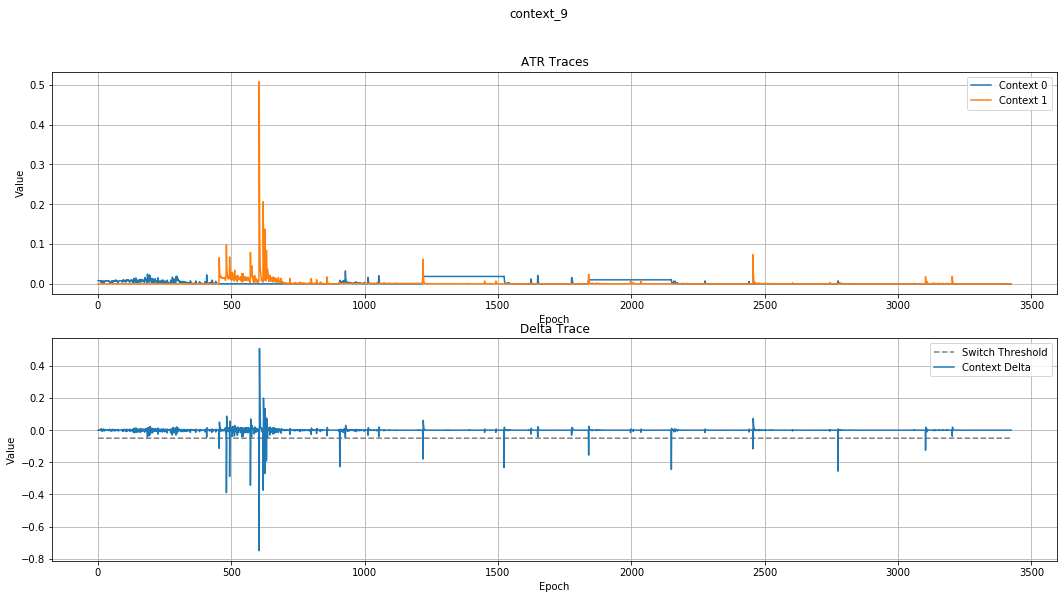

In [86]:
logger.plot(figsize=(18,9))

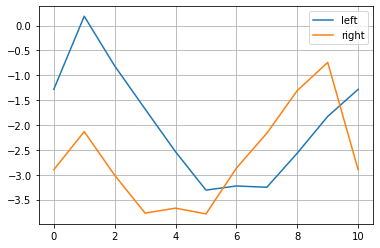

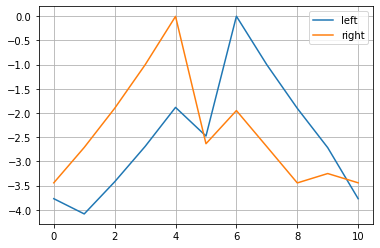

In [87]:
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)